In [11]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
from independence import *
from pre_process import *
from constants import *
import warnings
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.calibration import calibration_curve
warnings.simplefilter("ignore")

In [2]:
df = data_processing("data/NCDOT_BikePedCrash.csv")
features_df = features_engineer("data/NCDOT_BikePedCrash.csv")

In [3]:
features_df

,age_category,is_drunk_biker,month,severity,is_drunk_driver,y,x,speed_limit,is_wet,is_male,...,light_condition_Daylight,locality_Mixed (30% To 70% Developed),locality_Rural (<30% Developed),locality_Urban (>70% Developed),road_surface_type_Coarse Asphalt,road_surface_type_Concrete,road_surface_type_Smooth Asphalt,weather_Clear,weather_Cloudy,weather_Rain
0,11,0,1,2,0,36.039490,-78.883896,30,0,1,...,1,0,0,1,0,0,1,1,0,0
1,20,0,1,1,0,35.751118,-78.782800,30,0,1,...,1,0,0,1,0,0,1,1,0,0
2,30,0,1,2,0,35.084732,-80.697820,20,0,1,...,1,0,0,1,0,0,1,0,1,0
3,30,0,1,1,0,35.684400,-80.479320,30,0,1,...,1,0,0,1,0,0,1,0,1,0
4,40,0,1,2,0,34.999428,-78.904450,30,0,1,...,1,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11252,6,0,9,1,0,35.270257,-77.585864,30,0,0,...,1,0,0,1,1,0,0,1,0,0
11253,60,0,12,3,0,35.534234,-77.025772,30,0,0,...,1,0,0,1,1,0,0,1,0,0
11255,30,0,12,2,0,35.118065,-77.077608,30,0,1,...,1,0,0,1,0,0,1,1,0,0
11256,50,0,12,0,0,35.718750,-78.624247,30,0,1,...,1,0,0,1,1,0,0,1,0,0


In [5]:
def calculate_propensity_score(df, model, scale=False):
  df_copy = df.copy()
  X_df = df_copy[PROPENSITY_MODEL_FEATURES]
  t_true = df_copy[T_BINARY]

  if scale:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_df)
  else:
    X_scaled = X_df

  model.fit(X_scaled, t_true)
  propensity_scores = model.predict_proba(X_scaled)[:, 1]
  df_copy['propensity_score'] = propensity_scores
  return df_copy

In [6]:
lg_propensity_df = calculate_propensity_score(features_df, LogisticRegression(max_iter=100000, random_state=42), scale=True)
gb_propensity_df = calculate_propensity_score(features_df, GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=42), scale=True)
rf_propensity_df = calculate_propensity_score(features_df, RandomForestClassifier(n_estimators=100, random_state=42), scale=True)
knn_propensity_df = calculate_propensity_score(features_df, KNeighborsClassifier(n_neighbors=5), scale=True)

In [9]:
def plot_propensity_hist(propensity_df, model):   
    plt.hist(propensity_df[propensity_df[T_BINARY] == 1]['propensity_score'], fc=(0, 0, 1, 0.5), bins=20, label='Treated')
    plt.hist(propensity_df[propensity_df[T_BINARY] == 0]['propensity_score'], fc=(1, 0, 0, 0.5), bins=20, label='Control')
    plt.legend()
    plt.title(f'{model} propensity scores overlap')
    plt.yscale('log')
    plt.xlabel('propensity score')
    plt.ylabel('number of units (log scaled)')
    plt.show()

In [24]:
def plot_propensity_models_hist(propensities_dict):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.flatten()

    for i, (model, propensity_df) in enumerate(propensities_dict.items()):
        axs[i].hist(propensity_df[propensity_df[T_BINARY] == 1]['propensity_score'], 
                    fc=(0, 0, 1, 0.5), bins=20, label='Treated')
        axs[i].hist(propensity_df[propensity_df[T_BINARY] == 0]['propensity_score'], 
                    fc=(1, 0, 0, 0.5), bins=20, label='Control')
        axs[i].set_title(f'{model} propensity scores overlap')
        axs[i].set_yscale('log')
        axs[i].set_xlabel('propensity score')
        axs[i].set_ylabel('number of units (log scaled)')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

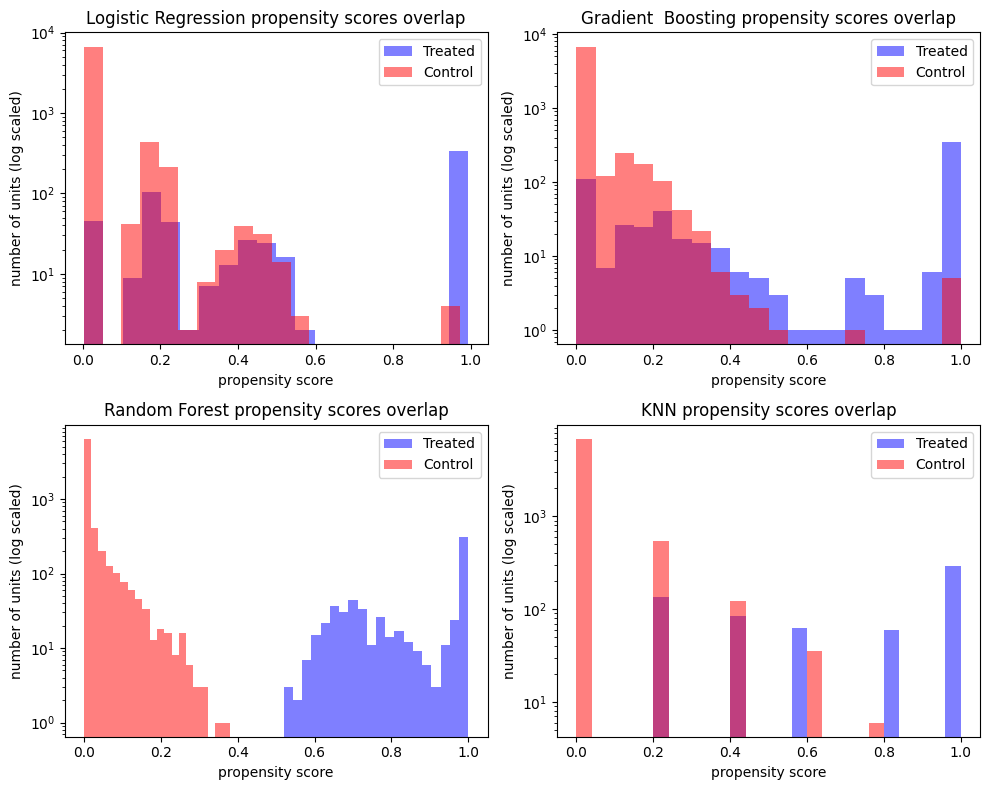

In [25]:
propensities_dict = {
                    'Logistic Regression': lg_propensity_df,
                     'Gradient  Boosting': gb_propensity_df,
                     'Random Forest': rf_propensity_df,
                     'KNN': knn_propensity_df
                    }
plot_propensity_models_hist(propensities_dict)

In [14]:
def plot_calibration_curve(models_dict, t_true):
    plt.figure(1, figsize=(10, 10))
    ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for model_name, propensity_df in models_dict.items():
        propensity = propensity_df['propensity_score']
        clf_score = brier_score_loss(t_true, propensity)
        fraction_of_positives, mean_predicted_value = calibration_curve(t_true, propensity, n_bins=10)

        ax1.plot(mean_predicted_value,
                 fraction_of_positives,
                 "s-",
                 label="%s (Brier: %1.3f)" % (model_name, clf_score))

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')
    ax1.set_xlabel("Mean predicted value")
    plt.tight_layout()
    plt.show()

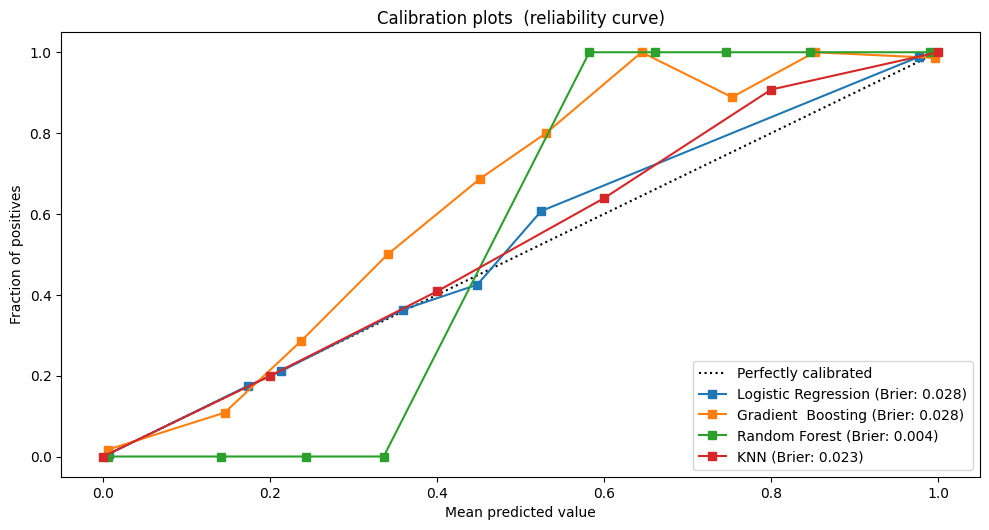

In [15]:
plot_calibration_curve(propensities_dict, features_df[T_BINARY])

In [ ]:
def calculate_ATT_IPW(df, model, scale=False):
  df_copy = calculate_propensity_score(df, model, scale=scale)
  propensity_score =  np.array(df_copy['propensity_score'])
  T = np.array(df_copy[T])
  Y =  np.array(df_copy[Y])

  p1 = (T * Y).sum() / T.sum()
  p2_numerator_sum = 0
  p2_denominator_sum = 0
  for i in range(len(T)):
    p2_numerator_sum += (1 - T[i]) * Y[i] * (propensity_score[i] / (1-propensity_score[i]))
    p2_denominator_sum += (1 - T[i]) * (propensity_score[i] / (1-propensity_score[i]))

  p2 = p2_numerator_sum / p2_denominator_sum
  return p1 - p2, propensity_score